In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from collections import deque


def encontrar_mas_cercana(salas, nuevo_centro_x, nuevo_centro_y):
    cercana = None
    min_dist = float('inf')
    for sala in salas:
        centro_x, centro_y = sala.get_centro()
        distancia = distancia_cuadrado(centro_x, centro_y, nuevo_centro_x, nuevo_centro_y)
        if distancia < min_dist:
            min_dist = distancia
            cercana = sala
    return cercana


def distancia_cuadrado(x1, y1, x2, y2):
    return (x1 - x2) ** 2 + (y1 - y2) ** 2


class Sala:
    def __init__(self, x, y, lado):
        self.x1 = x
        self.y1 = y
        self.x2 = x + lado
        self.y2 = y + lado

    def get_centro(self):
        centro_x = (self.x1 + self.x2) // 2
        centro_y = (self.y1 + self.y2) // 2
        return (centro_x, centro_y)

    def se_superpone(self, otra):
        return (self.x1 <= otra.x2 and self.x2 >= otra.x1 and
                self.y1 <= otra.y2 and self.y2 >= otra.y1)


class Dungeon:
    def __init__(self, anchura, altura, max_salas, semilla=None, intentos_por_sala=10):
        if semilla is not None:
            random.seed(semilla)
        self.mazmorra = [[0 for _ in range(anchura)] for _ in range(altura)]
        self.grafo = nx.Graph()
        self.centros = {}
        salas = []
        self.puertas = []


        for _ in range(max_salas):
            for _ in range(intentos_por_sala):
                lado = 5
                x = random.randint(0, anchura - lado - 1)
                y = random.randint(0, altura - lado - 1)
                nueva_sala = Sala(x, y, lado)

                if any(nueva_sala.se_superpone(otra_sala) for otra_sala in salas):
                    continue  # La sala se superpone, se descarta este intento

                sala_id = len(salas)
                self.centros[sala_id] = nueva_sala.get_centro()
                self.grafo.add_node(sala_id)
                
                if salas:
                    nuevo_centro_x, nuevo_centro_y = nueva_sala.get_centro()
                    cercana = encontrar_mas_cercana(salas, nuevo_centro_x, nuevo_centro_y)
                    cercana_id = salas.index(cercana)
                    cercana_centro_x, cercana_centro_y = cercana.get_centro()
                
                    self.crear_pasillo_horizontal(cercana_centro_x, nuevo_centro_x, cercana_centro_y)
                    self.crear_pasillo_vertical(cercana_centro_y, nuevo_centro_y, nuevo_centro_x)


                salas.append(nueva_sala)
                for x in range(nueva_sala.x1, nueva_sala.x2):
                    for y in range(nueva_sala.y1, nueva_sala.y2):
                        self.mazmorra[y][x] = 1  # Sala

                break  # Si se colocó correctamente, no hace falta seguir intentando
                
        self._construir_grafo_desde_matriz(salas)


    def crear_pasillo_horizontal(self, x1, x2, y):
        for x in range(min(x1, x2), max(x1, x2) + 1):
            if self.mazmorra[y][x] == 0:
                self.mazmorra[y][x] = 2  # Pasillo
    
    def crear_pasillo_vertical(self, y1, y2, x):
        for y in range(min(y1, y2), max(y1, y2) + 1):
            if self.mazmorra[y][x] == 0:
                self.mazmorra[y][x] = 2  # Pasillo
    
    def _construir_grafo_desde_matriz(self, salas):
        altura = len(self.mazmorra)
        anchura = len(self.mazmorra[0])
        mapa_salas = [[-1 for _ in range(anchura)] for _ in range(altura)]
    
        # 1. Mapear celdas de cada sala
        for i, sala in enumerate(salas):
            for x in range(sala.x1, sala.x2):
                for y in range(sala.y1, sala.y2):
                    mapa_salas[y][x] = i
    
        conectados = set()
    
        # 2. Para cada sala, buscar pasillos contiguos y hacer BFS solo por pasillos
        for i, sala in enumerate(salas):
            visitado = [[False for _ in range(anchura)] for _ in range(altura)]
            cola = deque()
    
            # Añadir las celdas frontera de la sala que estén pegadas a pasillo
            for x in range(sala.x1, sala.x2):
                for y in range(sala.y1, sala.y2):
                    for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < anchura and 0 <= ny < altura and self.mazmorra[ny][nx] == 2:
                            cola.append((nx, ny))
                            visitado[ny][nx] = True
    
            while cola:
                x, y = cola.popleft()
    
                # Revisar vecinos
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    nx, ny = x + dx, y + dy
                    if not (0 <= nx < anchura and 0 <= ny < altura):
                        continue
                    if visitado[ny][nx]:
                        continue
    
                    if self.mazmorra[ny][nx] == 2:
                        cola.append((nx, ny))
                        visitado[ny][nx] = True
    
                    elif self.mazmorra[ny][nx] == 1:
                        j = mapa_salas[ny][nx]
                        if j != -1 and j != i:
                            par = tuple(sorted((i, j)))
                            if par not in conectados:
                                distancia = ((self.centros[i][0] - self.centros[j][0]) ** 2 +
                                             (self.centros[i][1] - self.centros[j][1]) ** 2) ** 0.5
                                self.grafo.add_edge(i, j, weight=distancia)
                                conectados.add(par)

    
    def mostrar(self):
        # Crear mapa de colores: 0 = negro, 1 = blanco, 2 = gris
        cmap = ListedColormap(['black', 'white', 'gray'])
    
        plt.figure(figsize=(10, 6))
        plt.imshow(self.mazmorra, cmap=cmap, origin='upper')
        plt.title(str(self.semilla))
        plt.axis('off')
        plt.show()
    
    def mostrar_grafo(self):
        pos = self.centros
        labels = nx.get_edge_attributes(self.grafo, 'weight')
        nx.draw(self.grafo, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        nx.draw_networkx_edge_labels(self.grafo, pos, edge_labels={k: f"{v:.1f}" for k, v in labels.items()})
        plt.title("Grafo de conexión entre salas")
        plt.show()
        
    def mostrar_mapa_y_grafo(self):
        fig, ax = plt.subplots(figsize=(10, 6))
    
        # 1. Mostrar matriz con colormap
        cmap = ListedColormap(['black', 'white', 'gray'])  # 0 = pared, 1 = sala, 2 = pasillo
        ax.imshow(self.mazmorra, cmap=cmap, origin='upper')
    
        # 2. Dibujar grafo con nodos en el centro de cada sala
        pos = {k: (v[0], v[1]) for k, v in self.centros.items()}
        labels = nx.get_edge_attributes(self.grafo, 'weight')
    
        nx.draw(self.grafo, pos, with_labels=True, node_color='red', edge_color='yellow', node_size=400, ax=ax)
        nx.draw_networkx_edge_labels(self.grafo, pos, edge_labels={k: f"{v:.0f}" for k, v in labels.items()}, ax=ax)
    
        ax.set_title("Mazmorra y grafo superpuesto")
        ax.axis('off')
        plt.show()



# Función de utilidad para generación controlada
def generar_dungeon(anchura=60, altura=30, max_salas=10, semilla=None, intentos_por_sala=10):
    dungeon = Dungeon(anchura, altura, max_salas, semilla=semilla, intentos_por_sala=intentos_por_sala)
    dungeon.mostrar()
    dungeon.mostrar_mapa_y_grafo()
    return dungeon


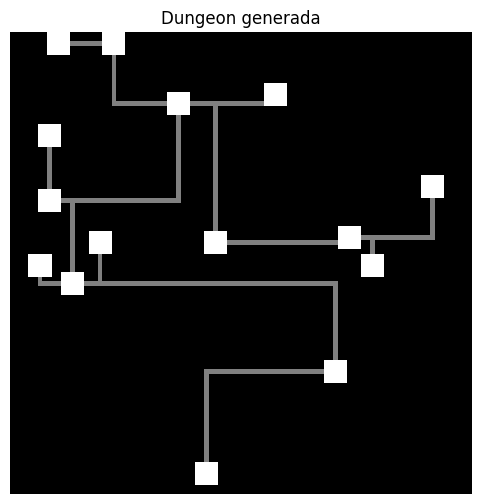

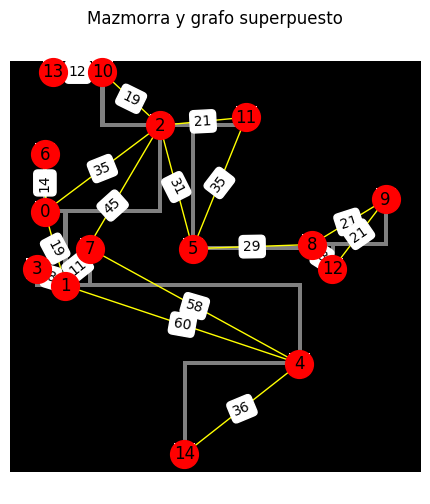

In [5]:
# Ejemplo de uso
dungeon = generar_dungeon(anchura=100, altura=100, max_salas=15, semilla=123)


In [3]:
def seleccionar_inicio_y_final(grafo):
    inicio = random.choice(list(grafo.nodes))
    distancias = nx.single_source_dijkstra_path_length(grafo, inicio)
    hojas = [n for n in grafo.nodes if grafo.degree[n] == 1]

    if hojas:
        final = max(hojas, key=lambda n: distancias.get(n, -1))
    else:
        final = max(distancias, key=distancias.get)

    return inicio, final


In [4]:
inicio, final = seleccionar_inicio_y_final(dungeon.grafo)
print(inicio, final)

7 14
